In [1]:
import os, sys, re, io, math
import matplotlib, shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Patch
from matplotlib.widgets import Slider
from collections import *
from math import isnan, nan
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from termcolor import colored
import ipywidgets as widgets
from IPython.display import *
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100000
pd.options.display.float_format = '{0:f}'.format

# Disable scrolling for all output widgets
style = """
    <style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
    </style>
    """
display(HTML(style))

# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

from core import *

# enable notebook mode so that we can drag, resize and save plots, but plot will be smaller
# %matplotlib notebook

Autosave disabled


<IPython.core.display.Javascript object>

# Inter-tap Interval (ITI) Distribution

In [33]:
# Main file path
ROOTPATH = "./3.decrypted"
studies = [p for p in os.listdir(ROOTPATH) if os.path.isdir(ROOTPATH+'/'+p)]
dd_study = widgets.Dropdown(options=studies, value=studies[0] if studies else None, description='Study')
def on_change_study(change):
    global userpath
    if change['type'] == 'change' and change['name'] == 'value':
        users = [u for u in os.listdir(ROOTPATH+'/'+dd_study.value) if os.path.isdir(ROOTPATH+'/'+dd_study.value+'/'+u)]
        dd_users.options = users
        dd_users.value = users[0] if users else None
        userpath = ROOTPATH+'/'+dd_study.value+'/'+dd_users.value
dd_study.observe(on_change_study)
users = [u for u in os.listdir(ROOTPATH+'/'+dd_study.value) if os.path.isdir(ROOTPATH+'/'+dd_study.value+'/'+u)]
dd_users = widgets.Dropdown(options=users, value=users[0] if users else None, description='User')
userpath = ROOTPATH + '/' + dd_study.value + '/' + dd_users.value
dd_plots = widgets.Dropdown(options=['direct (X, Y)', 'direct (logX, logY)', 'log uniform X (logY)'],
                            value='direct (X, Y)', style={'description_width': '100px'}, description='Histogram Type')
def drawOne(user, plot, bins, DoPlot):
    if not DoPlot:
        return None
    userpath = ROOTPATH + '/' + dd_study.value + '/' + user if '/' not in user else user
    df_taps = load_df(userpath+'/tapsLog.csv.gz', '', -1).drop(columns=['tz'])
    if len(df_taps.index)<30:
        print('Warning: too few taps (%d) to plot distribution!'%len(df_taps.index))
        return
    print('Total number of taps = %d, computing bins ...'%len(df_taps.index), flush=True)
    df_taps['timestamp'] = df_taps['timestamp'].shift(-1)-df_taps['timestamp']
    df_PS = load_df(userpath+'/powerState.csv.gz', '', -1).drop(columns=['tz', 'timestamp'])
    df_both = df_taps.join(df_PS, how='outer')
    df_intertap = df_both[df_both.event.shift(-1)!='Screen turned off']
    df_plot = df_intertap[(df_intertap.timestamp<100000) & (df_intertap.timestamp>0)][['timestamp']]\
        .rename(columns={'timestamp':'inter-tap interval / ms'})
    options = globals().get('g_plot_options', {})
    bins = int(round(np.log10(len(df_taps.index))*100)) if bins == 'auto' else bins
    if 'figsize' not in options:
        options['figsize'] = [16,9]
    if plot == 'direct (X, Y)':
        obj = df_plot.plot.hist(bins=bins, **options)
    elif plot == 'direct (logX, logY)':
        obj = df_plot.plot.hist(bins=bins, logx=True, logy=True, **options)
    elif plot == 'log uniform X (logY)':
        hi, lo = df_plot.values.max(), df_plot.values.min()
        obj = df_plot.plot.hist(bins=np.logspace(np.log10(lo), np.log10(hi), bins), logx=True, logy=True, **options)
    print('Plotting graph with %d bins ...'%bins, flush=True)
    return obj
do_plot = widgets.ToggleButton(value=False, description='Do Plot')
do_bins = widgets.IntText(value=10000, description='# of Bins')
W = interactive(drawOne, user=dd_users, plot=dd_plots, bins=do_bins, DoPlot=do_plot)
VBox([HBox((dd_study,)+W.children[0:-1]), W.children[-1]])

# Preview All Patients ITI Distribution

Button(description='Draw All', style=ButtonStyle(font_weight='bold'))

Total number of taps = 917888, computing bins ...
Plotting graph with 5963 bins ...
Total number of taps = 16926, computing bins ...
Plotting graph with 4229 bins ...
Total number of taps = 512786, computing bins ...
Plotting graph with 5710 bins ...
Total number of taps = 198480, computing bins ...
Plotting graph with 5298 bins ...
Total number of taps = 976, computing bins ...
Plotting graph with 2989 bins ...
Total number of taps = 2112503, computing bins ...
Plotting graph with 6325 bins ...
Total number of taps = 613807, computing bins ...
Plotting graph with 5788 bins ...
Total number of taps = 309, computing bins ...
Plotting graph with 2490 bins ...
Total number of taps = 1274170, computing bins ...
Plotting graph with 6105 bins ...
Total number of taps = 710250, computing bins ...
Plotting graph with 5851 bins ...
Total number of taps = 22109, computing bins ...
Plotting graph with 4345 bins ...
Total number of taps = 88983, computing bins ...
Plotting graph with 4949 bins ...

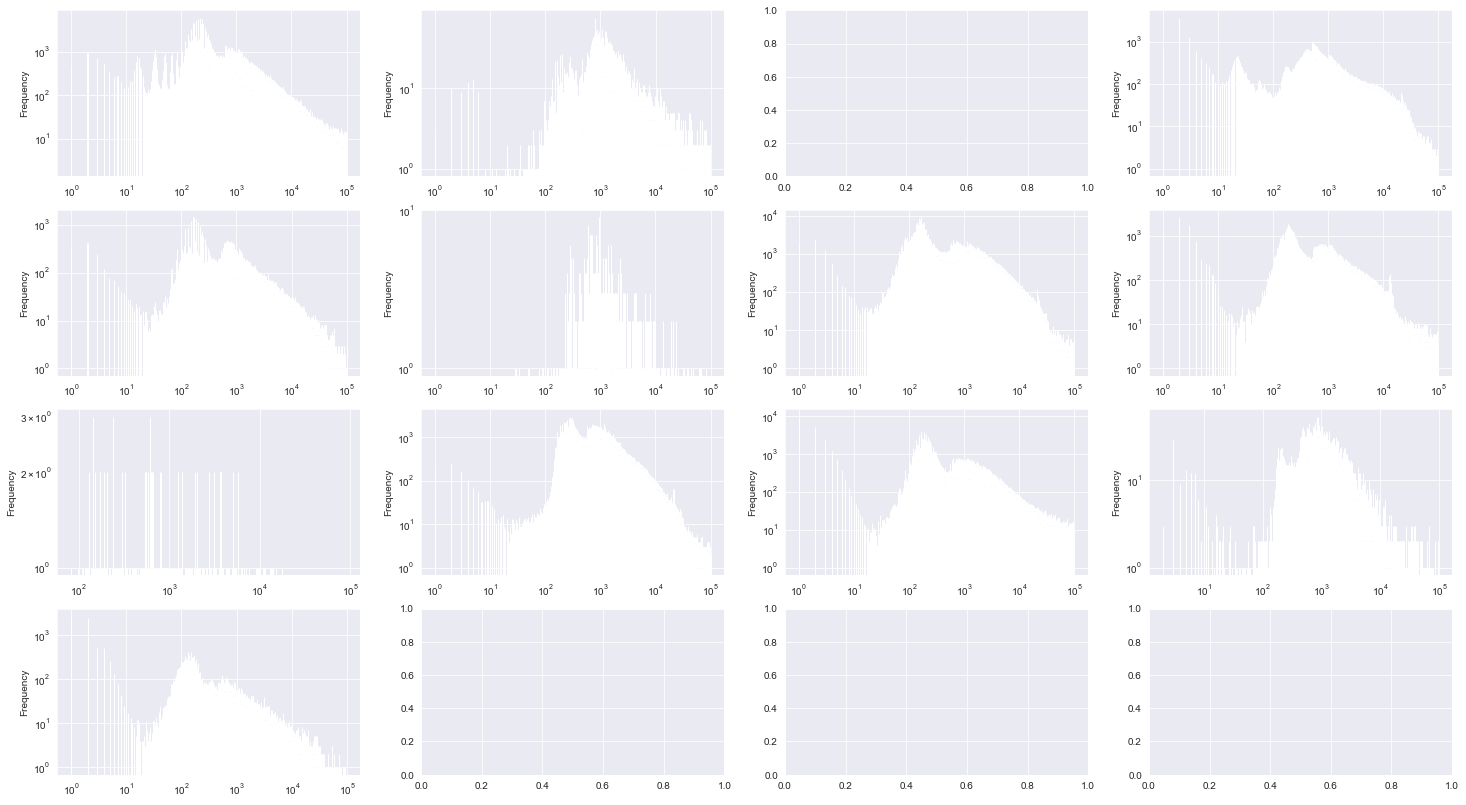

In [32]:
def drawAll(e):
    userpaths = [ROOTPATH+'/'+study+'/'+u for study in studies for u in os.listdir(ROOTPATH+'/'+study) if os.path.isdir(ROOTPATH+'/'+study+'/'+u)]
    ncol = 4
    nrow = int(np.ceil(len(userpaths)/4))
    W = 25
    H = W*(9/16)
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=[W,H])
    for ii, userpath in enumerate(userpaths):
        globals()['g_plot_options'] = {'ax':axs[ii//4, ii%4], 'figsize':[W,H]}
        drawOne(userpath, 'log uniform X (logY)', 'auto', True)
        if axs[ii//4, ii%4].get_legend() != None:
            axs[ii//4, ii%4].get_legend().remove()
button = widgets.Button(description='Draw All', style={'font_weight': 'bold'})
button.on_click(drawAll)
display(button)